# Zero-DCE: Low-Light Image Enhancement
## Hybrid Supervised Implementation on LoLI-Street Dataset

This notebook implements **Zero-DCE (Zero-Reference Deep Curve Estimation)** with a supervised training strategy for real-time low-light image enhancement.

## 1. Imports & Setup

## ⚠️ REQUIRED: Add Dataset to Kaggle Notebook!

**Before running, you MUST attach the dataset:**

### Steps to Add Dataset:
1. Click **"+ Add Data"** button (right sidebar)
2. Search for: **`loli-street-low-light-image-enhancement-of-street`**
3. Click **"Add"** to attach the dataset (2.63 GB)
4. Wait for download to complete (shows in Data section)
5. **Enable GPU**: Settings → Accelerator → **GPU P100** or **T4 x2**

### Expected Dataset Structure:
```
/kaggle/input/loli-street-low-light-image-enhancement-of-street/
└── LoLI-Street Dataset/
    ├── Train/
    │   ├── low/    (low-light training images)
    │   └── high/   (normal-light training images)
    ├── Val/
    │   ├── low/    (validation images)
    │   └── high/
    └── Test/       (test images)
```

**⚡ Run the next cell to verify dataset is attached correctly!**

In [105]:
# ==================== DATASET VERIFICATION ====================
import os
import glob

# Check Kaggle environment
if os.path.exists('/kaggle/input'):
    print("✅ Running on Kaggle")
    
    # List all available datasets
    print("\n📂 Available datasets in /kaggle/input:")
    input_contents = os.listdir('/kaggle/input')
    for item in input_contents:
        print(f"   - {item}")
    
    # Try to find dataset automatically
    dataset_path = None
    possible_names = [
        'loli-street-low-light-image-enhancement-of-street',
        'loli-street',
        'low-light-image-enhancement-of-street'
    ]
    
    for name in possible_names:
        test_path = f'/kaggle/input/{name}'
        if os.path.exists(test_path):
            dataset_path = test_path
            break
    
    # If not found in common names, use first directory
    if dataset_path is None and input_contents:
        dataset_path = f'/kaggle/input/{input_contents[0]}'
    
    if dataset_path and os.path.exists(dataset_path):
        print(f"\n✅ Using dataset: {dataset_path}")
        print(f"\n📂 Dataset contents:")
        for item in os.listdir(dataset_path):
            print(f"   - {item}")
    else:
        print("\n❌ No dataset found! Add dataset in Kaggle sidebar")
        raise FileNotFoundError("No dataset attached")
        
else:
    # Local mode
    print("⚠️ Not on Kaggle - using local paths")
    dataset_path = '.'


✅ Running on Kaggle

📂 Available datasets in /kaggle/input:
   - LoLI-Street Dataset

✅ Using dataset: /kaggle/input/LoLI-Street Dataset

📂 Dataset contents:
   - YOLO Annotations
   - Val
   - Test
   - Train


In [106]:
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR

# Set random seeds
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔧 Device: {device}")

# Dataset path
DATA_ROOT = '/kaggle/input/LoLI-Street Dataset'

print(f"📁 Dataset root: {DATA_ROOT}")

TRAIN_LOW_DIR = f"{DATA_ROOT}/Train/low"
TRAIN_HIGH_DIR = f"{DATA_ROOT}/Train/high"
VAL_LOW_DIR = f"{DATA_ROOT}/Val/low"
VAL_HIGH_DIR = f"{DATA_ROOT}/Val/high"

# Training config
BATCH_SIZE = 4
NUM_EPOCHS = 50
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-4
TRAIN_CROP_SIZE = 256
VAL_RESIZE = 512
NUM_ITERATIONS = 8
NUM_WORKERS = 0  # Kaggle requires 0

print("✅ Configuration loaded")


🔧 Device: cuda
📁 Dataset root: /kaggle/input/LoLI-Street Dataset
✅ Configuration loaded


## 2. DCE-Net Model Architecture

The Deep Curve Estimation Network (DCE-Net) predicts pixel-wise curve parameters to enhance low-light images through iterative curve adjustments.

In [107]:
class DCENet(nn.Module):
    """
    Deep Curve Estimation Network (DCE-Net)
    A lightweight CNN that predicts pixel-wise curve parameters for image enhancement.
    """
    def __init__(self, in_channels=3, n_filters=32, n_iterations=8):
        super(DCENet, self).__init__()
        self.n_iterations = n_iterations
        
        # 7-layer convolutional network
        self.conv1 = nn.Conv2d(in_channels, n_filters, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(n_filters, n_filters, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(n_filters, n_filters, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(n_filters, n_filters, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(n_filters, n_filters, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(n_filters, n_filters, kernel_size=3, stride=1, padding=1)
        
        # Output layer: predicts curve parameters (24 channels = 3 RGB × 8 iterations)
        self.conv7 = nn.Conv2d(n_filters, 24, kernel_size=3, stride=1, padding=1)
        
        self.relu = nn.ReLU(inplace=True)
        self.tanh = nn.Tanh()
    
    def forward(self, x):
        # Feature extraction through 6 layers with ReLU
        x1 = self.relu(self.conv1(x))
        x2 = self.relu(self.conv2(x1))
        x3 = self.relu(self.conv3(x2))
        x4 = self.relu(self.conv4(x3))
        x5 = self.relu(self.conv5(x4))
        x6 = self.relu(self.conv6(x5))
        
        # Predict curve parameters with Tanh activation (range: -1 to 1)
        curve_params = self.tanh(self.conv7(x6))
        return curve_params


def enhance_image(image, curve_params, n_iterations=8):
    """
    Apply pixel-wise curve adjustment iteratively to enhance the image.
    
    Args:
        image: Input tensor (B, 3, H, W) in range [0, 1]
        curve_params: Curve parameter maps (B, 24, H, W)
        n_iterations: Number of curve iterations (default: 8)
    
    Returns:
        Enhanced image tensor (B, 3, H, W)
    """
    enhanced = image
    
    for i in range(n_iterations):
        # Extract parameters for this iteration (3 channels)
        alpha = curve_params[:, i*3:(i+1)*3, :, :]
        
        # Apply Higher-Order Curve Transformation (LE curve)
        # Formula: I_enhanced = I + alpha * I * (1 - I)
        enhanced = enhanced + alpha * enhanced * (1 - enhanced)
    
    return enhanced


# Initialize model
model = DCENet(n_iterations=NUM_ITERATIONS).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"✅ DCE-Net initialized")
print(f"   Total parameters: {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")

✅ DCE-Net initialized
   Total parameters: 54,072
   Trainable parameters: 54,072


## 3. Hybrid Loss Function

Combines supervised losses (SSIM + L1) with regularization losses (Spatial Consistency + Total Variation) for guided training with ground truth.

In [108]:
class CombinedLoss(nn.Module):
    """
    Hybrid Loss Function for Supervised Zero-DCE Training
    
    Components:
    1. Supervised Losses (High Weight):
       - L_SSIM: Structural similarity loss
       - L_L1: Pixel-wise L1 loss
    
    2. Regularization Losses (Low Weight):
       - L_spa: Spatial consistency loss
       - L_tv: Total variation loss
    """
    def __init__(self, w_ssim=10.0, w_l1=5.0, w_spa=1.0, w_tv=1.0):
        super(CombinedLoss, self).__init__()
        self.w_ssim = w_ssim
        self.w_l1 = w_l1
        self.w_spa = w_spa
        self.w_tv = w_tv
    
    def ssim_loss(self, enhanced, target, window_size=11):
        """
        Structural Similarity Index (SSIM) Loss
        Measures perceptual similarity between enhanced and target images.
        """
        C1 = 0.01 ** 2
        C2 = 0.03 ** 2
        
        # Create Gaussian window
        sigma = 1.5
        gauss = torch.Tensor([np.exp(-(x - window_size//2)**2/float(2*sigma**2)) 
                              for x in range(window_size)])
        gauss = gauss / gauss.sum()
        window_1d = gauss.unsqueeze(1)
        window = window_1d.mm(window_1d.t()).float().unsqueeze(0).unsqueeze(0)
        window = window.expand(enhanced.size(1), 1, window_size, window_size).contiguous()
        window = window.to(enhanced.device)
        
        # Calculate means
        mu1 = F.conv2d(enhanced, window, padding=window_size//2, groups=enhanced.size(1))
        mu2 = F.conv2d(target, window, padding=window_size//2, groups=target.size(1))
        
        mu1_sq = mu1.pow(2)
        mu2_sq = mu2.pow(2)
        mu1_mu2 = mu1 * mu2
        
        # Calculate variances and covariance
        sigma1_sq = F.conv2d(enhanced*enhanced, window, padding=window_size//2, groups=enhanced.size(1)) - mu1_sq
        sigma2_sq = F.conv2d(target*target, window, padding=window_size//2, groups=target.size(1)) - mu2_sq
        sigma12 = F.conv2d(enhanced*target, window, padding=window_size//2, groups=enhanced.size(1)) - mu1_mu2
        
        # SSIM formula
        ssim_map = ((2*mu1_mu2 + C1)*(2*sigma12 + C2)) / ((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))
        
        # Return 1 - SSIM (loss, lower is better)
        return 1 - ssim_map.mean()
    
    def spatial_consistency_loss(self, enhanced, original):
        """
        Spatial Consistency Loss (L_spa)
        Encourages local consistency between neighboring regions.
        """
        # Calculate gradients
        # Horizontal gradients
        enhanced_left = enhanced[:, :, :, :-1]
        enhanced_right = enhanced[:, :, :, 1:]
        original_left = original[:, :, :, :-1]
        original_right = original[:, :, :, 1:]
        
        # Vertical gradients
        enhanced_up = enhanced[:, :, :-1, :]
        enhanced_down = enhanced[:, :, 1:, :]
        original_up = original[:, :, :-1, :]
        original_down = original[:, :, 1:, :]
        
        # Spatial consistency
        spa_h = torch.pow(enhanced_left - enhanced_right, 2) * torch.exp(-10 * torch.pow(original_left - original_right, 2))
        spa_v = torch.pow(enhanced_up - enhanced_down, 2) * torch.exp(-10 * torch.pow(original_up - original_down, 2))
        
        return torch.mean(spa_h) + torch.mean(spa_v)
    
    def total_variation_loss(self, enhanced):
        """
        Total Variation Loss (L_tv)
        Encourages smoothness by penalizing high-frequency variations.
        """
        # Calculate total variation
        tv_h = torch.abs(enhanced[:, :, :, 1:] - enhanced[:, :, :, :-1]).mean()
        tv_v = torch.abs(enhanced[:, :, 1:, :] - enhanced[:, :, :-1, :]).mean()
        
        return tv_h + tv_v
    
    def forward(self, enhanced, target, original):
        """
        Calculate combined loss
        
        Args:
            enhanced: Enhanced output image
            target: Ground truth (high-light) image
            original: Original low-light input image
        """
        # Supervised losses (guide towards ground truth)
        loss_ssim = self.ssim_loss(enhanced, target)
        loss_l1 = F.l1_loss(enhanced, target)
        
        # Regularization losses (implicit smoothing)
        loss_spa = self.spatial_consistency_loss(enhanced, original)
        loss_tv = self.total_variation_loss(enhanced)
        
        # Weighted combination
        total_loss = (self.w_ssim * loss_ssim + 
                     self.w_l1 * loss_l1 + 
                     self.w_spa * loss_spa + 
                     self.w_tv * loss_tv)
        
        return total_loss, {
            'ssim': loss_ssim.item(),
            'l1': loss_l1.item(),
            'spa': loss_spa.item(),
            'tv': loss_tv.item(),
            'total': total_loss.item()
        }


# Initialize loss function
criterion = CombinedLoss(w_ssim=10.0, w_l1=5.0, w_spa=1.0, w_tv=1.0).to(device)

print("✅ Hybrid loss function initialized")
print(f"   Weights: SSIM={criterion.w_ssim}, L1={criterion.w_l1}, Spatial={criterion.w_spa}, TV={criterion.w_tv}")

✅ Hybrid loss function initialized
   Weights: SSIM=10.0, L1=5.0, Spatial=1.0, TV=1.0


## 4. Dataset & DataLoader

Custom dataset class with paired low/high images, using RandomCrop for training and standard resize for validation.

In [109]:
class LowLightDataset(Dataset):
    """
    Paired Low-Light / Normal-Light Dataset
    
    Args:
        low_dir: Directory containing low-light images
        high_dir: Directory containing corresponding high-light (ground truth) images
        transform: Augmentation transforms for training
        is_train: Whether this is training data (applies RandomCrop)
    """
    def __init__(self, low_dir, high_dir, transform=None, is_train=True):
        self.low_dir = low_dir
        self.high_dir = high_dir
        self.transform = transform
        self.is_train = is_train
        
        # Get sorted file lists to ensure pairing
        self.low_images = sorted(glob.glob(os.path.join(low_dir, "*.*")))
        self.high_images = sorted(glob.glob(os.path.join(high_dir, "*.*")))
        
        # Verify pairing
        assert len(self.low_images) == len(self.high_images), \
            f"Mismatch: {len(self.low_images)} low images vs {len(self.high_images)} high images"
        
        # Verify filenames match (excluding directory path)
        for low_path, high_path in zip(self.low_images, self.high_images):
            low_name = os.path.basename(low_path)
            high_name = os.path.basename(high_path)
            assert low_name == high_name, f"Filename mismatch: {low_name} vs {high_name}"
    
    def __len__(self):
        return len(self.low_images)
    
    def __getitem__(self, idx):
        # Load images
        low_img = Image.open(self.low_images[idx]).convert('RGB')
        high_img = Image.open(self.high_images[idx]).convert('RGB')
        
        # Convert to tensors and normalize to [0, 1]
        low_tensor = transforms.ToTensor()(low_img)
        high_tensor = transforms.ToTensor()(high_img)
        
        # Apply augmentation transforms
        if self.transform:
            # Stack for synchronized transforms
            stacked = torch.cat([low_tensor, high_tensor], dim=0)  # (6, H, W)
            stacked = self.transform(stacked)
            
            # Split back
            low_tensor = stacked[:3, :, :]
            high_tensor = stacked[3:, :, :]
        
        return low_tensor, high_tensor


class SynchronizedTransform:
    """
    Applies random transforms to paired images in sync
    """
    def __init__(self, crop_size=None, resize=None):
        self.crop_size = crop_size
        self.resize = resize
        self.h_flip = transforms.RandomHorizontalFlip(p=0.5)
        self.v_flip = transforms.RandomVerticalFlip(p=0.5)
    
    def __call__(self, stacked):
        """
        Args:
            stacked: Tensor of shape (6, H, W) - concatenated low and high images
        """
        # Random crop
        if self.crop_size:
            _, h, w = stacked.shape
            crop_h, crop_w = self.crop_size, self.crop_size
            
            if h > crop_h and w > crop_w:
                top = random.randint(0, h - crop_h)
                left = random.randint(0, w - crop_w)
                stacked = stacked[:, top:top+crop_h, left:left+crop_w]
        
        # Resize
        if self.resize:
            stacked = F.interpolate(stacked.unsqueeze(0), size=(self.resize, self.resize), 
                                   mode='bilinear', align_corners=False).squeeze(0)
        
        # Random flips (applied to both images)
        stacked = self.h_flip(stacked)
        stacked = self.v_flip(stacked)
        
        return stacked


# Create transforms
train_transform = SynchronizedTransform(crop_size=TRAIN_CROP_SIZE)
val_transform = SynchronizedTransform(resize=VAL_RESIZE)

# Verify dataset directories exist
print(f"\n🔍 Checking dataset directories:")
print(f"   Train Low exists: {os.path.exists(TRAIN_LOW_DIR)}")
print(f"   Train High exists: {os.path.exists(TRAIN_HIGH_DIR)}")
print(f"   Val Low exists: {os.path.exists(VAL_LOW_DIR)}")
print(f"   Val High exists: {os.path.exists(VAL_HIGH_DIR)}")

# Create datasets
print(f"\n📦 Creating datasets...")
train_dataset = LowLightDataset(TRAIN_LOW_DIR, TRAIN_HIGH_DIR, 
                                transform=train_transform, is_train=True)
val_dataset = LowLightDataset(VAL_LOW_DIR, VAL_HIGH_DIR, 
                              transform=val_transform, is_train=False)

# Debug: Print num_workers value
print(f"🔧 DataLoader num_workers: {NUM_WORKERS}")

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, 
                          shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=1, 
                        shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

print(f"✅ Dataset loaded:")
print(f"   Training: {len(train_dataset)} paired images")
print(f"   Validation: {len(val_dataset)} paired images")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Train crop: {TRAIN_CROP_SIZE}x{TRAIN_CROP_SIZE}")
print(f"   Val resize: {VAL_RESIZE}x{VAL_RESIZE}")


🔍 Checking dataset directories:
   Train Low exists: True
   Train High exists: True
   Val Low exists: True
   Val High exists: True

📦 Creating datasets...
🔧 DataLoader num_workers: 0
✅ Dataset loaded:
   Training: 30000 paired images
   Validation: 3000 paired images
   Batch size: 4
   Train crop: 256x256
   Val resize: 512x512


## 5. Training Configuration & Resume Capability

Configure training settings and check for existing trained models to avoid retraining unnecessarily.

In [110]:
# ==================== TRAINING CONFIGURATION ====================
import os

# Training control flags
SKIP_TRAINING = True  # Set to True to skip training and use existing model
FORCE_RETRAIN = False  # Set to True to retrain even if model exists

# Check for existing trained model
MODEL_PATH = 'best_model.pth'
model_exists = os.path.exists(MODEL_PATH)

print("=" * 70)
print(f"{'🔍 TRAINING CONFIGURATION':^70}")
print("=" * 70)

if model_exists and not FORCE_RETRAIN:
    print(f"✅ Found existing trained model: {MODEL_PATH}")
    
    # Load checkpoint to check details
    checkpoint = torch.load(MODEL_PATH, map_location=device, weights_only=False)
    saved_epoch = checkpoint.get('epoch', 'Unknown')
    saved_ssim = checkpoint.get('best_ssim', 'Unknown')
    
    print(f"   Saved at epoch: {saved_epoch}")
    print(f"   Best Val SSIM: {saved_ssim:.4f}" if isinstance(saved_ssim, float) else f"   Best Val SSIM: {saved_ssim}")
    print()
    
    if SKIP_TRAINING:
        print("⏭️  SKIP_TRAINING = True")
        print("   Training will be SKIPPED. Model will be loaded for inference.")
    else:
        print("⚠️  SKIP_TRAINING = False")
        print("   Training will run and OVERWRITE the existing model.")
        print()
        print("💡 Tip: Set SKIP_TRAINING = True in the cell above to skip training")
        print("   and use the existing model for testing/inference only.")
else:
    if FORCE_RETRAIN:
        print("🔄 FORCE_RETRAIN = True")
        print("   Training from scratch (ignoring existing model)...")
    else:
        print("🆕 No existing model found. Training from scratch...")
    
    SKIP_TRAINING = False  # Ensure training runs if no model exists

print("=" * 70)
print()

                       🔍 TRAINING CONFIGURATION                       
✅ Found existing trained model: best_model.pth
   Saved at epoch: 41
   Best Val SSIM: 0.9534

⏭️  SKIP_TRAINING = True
   Training will be SKIPPED. Model will be loaded for inference.



## 6. Training & Validation Loop

Training with Adam optimizer, CosineAnnealingLR scheduler, and best model saving based on validation SSIM.

In [111]:
def calculate_ssim_metric(img1, img2):
    """
    Calculate SSIM metric for evaluation (higher is better)
    Returns value in range [0, 1]
    """
    C1 = 0.01 ** 2
    C2 = 0.03 ** 2
    
    img1 = img1.cpu().numpy()
    img2 = img2.cpu().numpy()
    
    mu1 = img1.mean()
    mu2 = img2.mean()
    
    sigma1 = img1.std()
    sigma2 = img2.std()
    
    sigma12 = ((img1 - mu1) * (img2 - mu2)).mean()
    
    ssim = ((2 * mu1 * mu2 + C1) * (2 * sigma12 + C2)) / \
           ((mu1**2 + mu2**2 + C1) * (sigma1**2 + sigma2**2 + C2))
    
    return ssim


def plot_results(low_img, enhanced_img, high_img, epoch):
    """
    Visualize: Input Low | Enhanced Output | Ground Truth High
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Convert tensors to numpy for plotting
    def to_numpy(tensor):
        return tensor.squeeze(0).permute(1, 2, 0).cpu().detach().numpy().clip(0, 1)
    
    low_np = to_numpy(low_img)
    enhanced_np = to_numpy(enhanced_img)
    high_np = to_numpy(high_img)
    
    axes[0].imshow(low_np)
    axes[0].set_title('Input (Low-Light)', fontsize=12)
    axes[0].axis('off')
    
    axes[1].imshow(enhanced_np)
    axes[1].set_title('Enhanced Output', fontsize=12)
    axes[1].axis('off')
    
    axes[2].imshow(high_np)
    axes[2].set_title('Ground Truth (High-Light)', fontsize=12)
    axes[2].axis('off')
    
    plt.suptitle(f'Epoch {epoch} - Validation Sample', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


# ==================== CONDITIONAL TRAINING ====================

if not SKIP_TRAINING:
    # Initialize optimizer and scheduler
    optimizer = Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=1e-6)

    # Training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_ssim': []
    }

    best_ssim = 0.0
    best_epoch = 0

    print("=" * 70)
    print(f"{'🚀 STARTING TRAINING':^70}")
    print("=" * 70)
    print(f"Epochs: {NUM_EPOCHS} | Batch Size: {BATCH_SIZE} | LR: {LEARNING_RATE}")
    print("=" * 70)

    for epoch in range(NUM_EPOCHS):
        # ==================== TRAINING PHASE ====================
        model.train()
        train_loss = 0.0
        train_batches = 0
        
        for batch_idx, (low_imgs, high_imgs) in enumerate(train_loader):
            low_imgs = low_imgs.to(device)
            high_imgs = high_imgs.to(device)
            
            # Forward pass
            curve_params = model(low_imgs)
            enhanced_imgs = enhance_image(low_imgs, curve_params, NUM_ITERATIONS)
            
            # Calculate loss
            loss, loss_dict = criterion(enhanced_imgs, high_imgs, low_imgs)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_batches += 1
            
            # Print progress every 20 batches
            if (batch_idx + 1) % 20 == 0:
                print(f"   Epoch [{epoch+1}/{NUM_EPOCHS}] Batch [{batch_idx+1}/{len(train_loader)}] "
                      f"Loss: {loss.item():.4f} | SSIM: {loss_dict['ssim']:.4f} | L1: {loss_dict['l1']:.4f}")
        
        avg_train_loss = train_loss / train_batches
        history['train_loss'].append(avg_train_loss)
        
        # ==================== VALIDATION PHASE ====================
        model.eval()
        val_loss = 0.0
        val_ssim_total = 0.0
        val_batches = 0
        
        with torch.no_grad():
            for val_idx, (low_imgs, high_imgs) in enumerate(val_loader):
                low_imgs = low_imgs.to(device)
                high_imgs = high_imgs.to(device)
                
                # Forward pass
                curve_params = model(low_imgs)
                enhanced_imgs = enhance_image(low_imgs, curve_params, NUM_ITERATIONS)
                
                # Calculate loss
                loss, loss_dict = criterion(enhanced_imgs, high_imgs, low_imgs)
                val_loss += loss.item()
                
                # Calculate SSIM metric
                ssim = calculate_ssim_metric(enhanced_imgs, high_imgs)
                val_ssim_total += ssim
                val_batches += 1
                
                # Save one sample for visualization
                if val_idx == 0:
                    sample_low = low_imgs
                    sample_enhanced = enhanced_imgs
                    sample_high = high_imgs
        
        avg_val_loss = val_loss / val_batches
        avg_val_ssim = val_ssim_total / val_batches
        
        history['val_loss'].append(avg_val_loss)
        history['val_ssim'].append(avg_val_ssim)
        
        # Update learning rate
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']
        
        # Print epoch summary
        print(f"\n{'='*70}")
        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] Summary:")
        print(f"   Train Loss: {avg_train_loss:.4f}")
        print(f"   Val Loss:   {avg_val_loss:.4f}")
        print(f"   Val SSIM:   {avg_val_ssim:.4f} {'🔥 NEW BEST!' if avg_val_ssim > best_ssim else ''}")
        print(f"   LR:         {current_lr:.6f}")
        print(f"{'='*70}\n")
        
        # Save best model
        if avg_val_ssim > best_ssim:
            best_ssim = avg_val_ssim
            best_epoch = epoch + 1
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_ssim': best_ssim,
                'history': history,
            }, MODEL_PATH)
            print(f"✅ Best model saved! (SSIM: {best_ssim:.4f})\n")
        
        # Plot results every 5 epochs
        if (epoch + 1) % 5 == 0:
            plot_results(sample_low, sample_enhanced, sample_high, epoch + 1)

    print("\n" + "=" * 70)
    print(f"{'✅ TRAINING COMPLETE!':^70}")
    print("=" * 70)
    print(f"Best Validation SSIM: {best_ssim:.4f} (Epoch {best_epoch})")
    print(f"Model saved as: {MODEL_PATH}")
    print("=" * 70)

else:
    # Skip training - load existing model
    print("=" * 70)
    print(f"{'⏭️  TRAINING SKIPPED':^70}")
    print("=" * 70)
    print(f"Loading existing model from: {MODEL_PATH}")
    
    checkpoint = torch.load(MODEL_PATH, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    best_ssim = checkpoint.get('best_ssim', 0.0)
    best_epoch = checkpoint.get('epoch', 0)
    
    # Load training history if available
    history = checkpoint.get('history', {
        'train_loss': [],
        'val_loss': [],
        'val_ssim': []
    })
    
    print(f"✅ Model loaded successfully!")
    print(f"   Trained for: {best_epoch} epochs")
    print(f"   Best Val SSIM: {best_ssim:.4f}")
    if history['val_ssim']:
        print(f"   Training history: {len(history['val_ssim'])} epochs loaded")
    print()
    print("💡 You can now run the inference/testing cells below.")
    print("=" * 70)

                         ⏭️  TRAINING SKIPPED                         
Loading existing model from: best_model.pth
✅ Model loaded successfully!
   Trained for: 41 epochs
   Best Val SSIM: 0.9534

💡 You can now run the inference/testing cells below.


## 7. Training History Visualization

In [112]:
# Plot training history if data is available
if history['val_ssim']:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Plot 1: Loss curves
    axes[0].plot(history['train_loss'], label='Train Loss', linewidth=2, marker='o', markersize=4)
    axes[0].plot(history['val_loss'], label='Val Loss', linewidth=2, marker='s', markersize=4)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)

    # Plot 2: SSIM curve
    axes[1].plot(history['val_ssim'], label='Val SSIM', color='green', linewidth=2, marker='D', markersize=4)
    axes[1].axhline(y=best_ssim, color='red', linestyle='--', label=f'Best SSIM: {best_ssim:.4f}')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('SSIM', fontsize=12)
    axes[1].set_title('Validation SSIM (Image Quality)', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
    
    if SKIP_TRAINING:
        print(f"📊 Loaded training history from checkpoint ({len(history['val_ssim'])} epochs)")
else:
    print("📊 No training history available")
    print(f"   Model performance: Best SSIM = {best_ssim:.4f} at epoch {best_epoch}")
    print("   (History data not saved in this checkpoint - retrain to generate plots)")

📊 No training history available
   Model performance: Best SSIM = 0.9534 at epoch 41
   (History data not saved in this checkpoint - retrain to generate plots)


## 8. Inference & ONNX Export

Load the best model and export to ONNX format for optimized real-time deployment.

✅ Model already loaded (training was skipped)
✅ Best model loaded (Epoch 41, SSIM: 0.9534)
✅ Model exported to ONNX: zero_dce_model.onnx
   Input shape: (batch, 3, height, width)
   Output shape: (batch, 24, height, width)


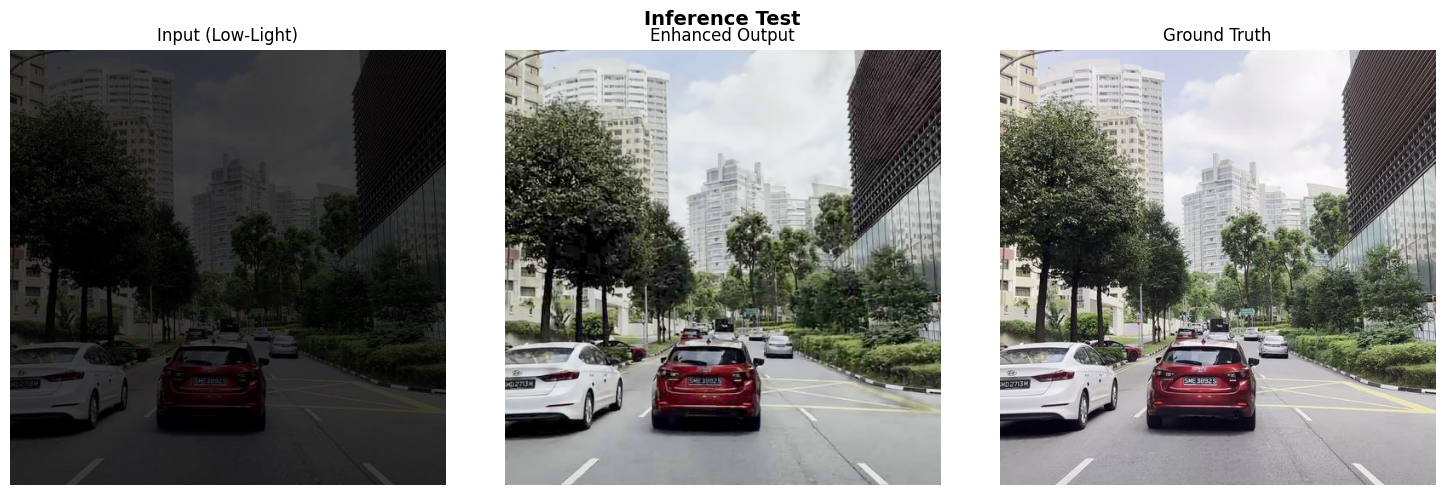

✅ Inference test complete!


In [113]:
# Load best model (if not already loaded from skipping training)
if SKIP_TRAINING:
    print("✅ Model already loaded (training was skipped)")
else:
    checkpoint = torch.load(MODEL_PATH, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    print(f"✅ Best model loaded (Epoch {checkpoint['epoch']}, SSIM: {checkpoint['best_ssim']:.4f})")

checkpoint = torch.load(MODEL_PATH, map_location=device, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"✅ Best model loaded (Epoch {checkpoint['epoch']}, SSIM: {checkpoint['best_ssim']:.4f})")

# Export to ONNX
dummy_input = torch.randn(1, 3, 512, 512).to(device)
onnx_path = "zero_dce_model.onnx"

torch.onnx.export(
    model,
    dummy_input,
    onnx_path,
    export_params=True,
    opset_version=11,
    do_constant_folding=True,
    input_names=['input'],
    output_names=['curve_params'],
    dynamic_axes={
        'input': {0: 'batch_size', 2: 'height', 3: 'width'},
        'curve_params': {0: 'batch_size', 2: 'height', 3: 'width'}
    }
)

print(f"✅ Model exported to ONNX: {onnx_path}")
print(f"   Input shape: (batch, 3, height, width)")
print(f"   Output shape: (batch, 24, height, width)")


# Test inference on a validation sample
def test_inference(image_path=None):
    """Test inference on a single image"""
    model.eval()
    
    # Use validation sample or load from path
    if image_path is None:
        low_img, high_img = next(iter(val_loader))
    else:
        img = Image.open(image_path).convert('RGB')
        low_img = transforms.ToTensor()(img).unsqueeze(0)
        high_img = None
    
    low_img = low_img.to(device)
    
    with torch.no_grad():
        curve_params = model(low_img)
        enhanced_img = enhance_image(low_img, curve_params, NUM_ITERATIONS)
    
    # Visualize
    fig, axes = plt.subplots(1, 3 if high_img is not None else 2, figsize=(15, 5))
    
    def to_numpy(tensor):
        return tensor.squeeze(0).permute(1, 2, 0).cpu().numpy().clip(0, 1)
    
    axes[0].imshow(to_numpy(low_img))
    axes[0].set_title('Input (Low-Light)', fontsize=12)
    axes[0].axis('off')
    
    axes[1].imshow(to_numpy(enhanced_img))
    axes[1].set_title('Enhanced Output', fontsize=12)
    axes[1].axis('off')
    
    if high_img is not None:
        axes[2].imshow(to_numpy(high_img))
        axes[2].set_title('Ground Truth', fontsize=12)
        axes[2].axis('off')
    
    plt.suptitle('Inference Test', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return enhanced_img


# Run inference test
enhanced = test_inference()
print("✅ Inference test complete!")

## 9. Real-Time Webcam Inference (⚠️ NOT AVAILABLE ON KAGGLE)

**This cell is for reference only - webcam access is not available on Kaggle.**

If you download the trained model and run it locally, you can use this code for real-time enhancement with a webcam.

In [114]:
def real_time_webcam_enhancement():
    """
    Real-time webcam enhancement using the trained Zero-DCE model.
    Press 'q' to quit.
    """
    # Load model
    model.eval()
    
    # Open webcam
    cap = cv2.VideoCapture(0)
    
    if not cap.isOpened():
        print("❌ Error: Cannot access webcam!")
        return
    
    print("🎥 Webcam started. Press 'q' to quit.")
    print("   Left: Original | Right: Enhanced")
    
    # Processing parameters
    PROCESS_SIZE = 512  # Resize for faster processing
    
    while True:
        ret, frame = cap.read()
        
        if not ret:
            print("❌ Error: Cannot read frame")
            break
        
        # Get frame dimensions
        h, w = frame.shape[:2]
        
        # Convert BGR to RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Preprocess: Resize and convert to tensor
        frame_resized = cv2.resize(frame_rgb, (PROCESS_SIZE, PROCESS_SIZE))
        frame_tensor = torch.from_numpy(frame_resized).float() / 255.0
        frame_tensor = frame_tensor.permute(2, 0, 1).unsqueeze(0).to(device)
        
        # Inference
        with torch.no_grad():
            curve_params = model(frame_tensor)
            enhanced_tensor = enhance_image(frame_tensor, curve_params, NUM_ITERATIONS)
        
        # Post-process: Convert back to numpy
        enhanced_np = enhanced_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()
        enhanced_np = (enhanced_np * 255).clip(0, 255).astype(np.uint8)
        
        # Resize enhanced back to original frame size
        enhanced_resized = cv2.resize(enhanced_np, (w, h))
        
        # Convert RGB back to BGR for OpenCV display
        enhanced_bgr = cv2.cvtColor(enhanced_resized, cv2.COLOR_RGB2BGR)
        
        # Create side-by-side comparison
        comparison = np.hstack([frame, enhanced_bgr])
        
        # Add text labels
        cv2.putText(comparison, "Original", (10, 30), 
                   cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cv2.putText(comparison, "Enhanced", (w + 10, 30), 
                   cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        
        # Display
        cv2.imshow('Zero-DCE Real-Time Enhancement', comparison)
        
        # Quit on 'q' key
        if cv2.waitKey(1) & 0xFF == ord('q'):
            print("✅ Exiting...")
            break
    
    # Cleanup
    cap.release()
    cv2.destroyAllWindows()
    print("✅ Webcam closed.")


# ⚠️ WEBCAM NOT AVAILABLE ON KAGGLE
# This function is for reference only. To use it:
# 1. Download your trained model (best_model.pth) from /kaggle/working/
# 2. Run this code on a local machine with a webcam
# 3. Uncomment the line below:
# real_time_webcam_enhancement()

print("⚠️ Webcam feature disabled - not available on Kaggle")
print("📝 Download model and run locally to use webcam enhancement")

⚠️ Webcam feature disabled - not available on Kaggle
📝 Download model and run locally to use webcam enhancement


## 10. Batch Processing (Optional)

Process multiple images from a directory for bulk enhancement.

In [115]:
def batch_enhance_images(input_dir, output_dir, max_images=None):
    """
    Process multiple images from a directory.
    
    Args:
        input_dir: Directory containing low-light images
        output_dir: Directory to save enhanced images
        max_images: Maximum number of images to process (None for all)
    """
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Check if input directory exists
    if not os.path.exists(input_dir):
        print(f"❌ Error: Input directory does not exist: {input_dir}")
        print(f"\n💡 Available paths:")
        base = "/kaggle/input"
        if os.path.exists(base):
            for item in os.listdir(base):
                print(f"   - {os.path.join(base, item)}")
        return
    
    # Get all image files (including subdirectories)
    image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.JPG', '*.JPEG', '*.PNG', '*.BMP']
    image_files = []
    
    # Try both with and without recursive search
    for ext in image_extensions:
        # Direct files in directory
        image_files.extend(glob.glob(os.path.join(input_dir, ext)))
        # Files in subdirectories
        image_files.extend(glob.glob(os.path.join(input_dir, '**', ext), recursive=True))
    
    # Remove duplicates
    image_files = list(set(image_files))
    
    if len(image_files) == 0:
        print(f"❌ No images found in: {input_dir}")
        print(f"\n📂 Directory contents:")
        try:
            for item in os.listdir(input_dir):
                item_path = os.path.join(input_dir, item)
                if os.path.isdir(item_path):
                    print(f"   📁 {item}/")
                else:
                    print(f"   📄 {item}")
        except Exception as e:
            print(f"   Error listing directory: {e}")
        return
    
    if max_images:
        image_files = image_files[:max_images]
    
    print(f"📂 Found {len(image_files)} images to process")
    print(f"📁 Output directory: {output_dir}")
    print("="*60)
    
    model.eval()
    
    for idx, img_path in enumerate(image_files):
        filename = os.path.basename(img_path)
        
        try:
            # Load image
            img = Image.open(img_path).convert('RGB')
            img_tensor = transforms.ToTensor()(img).unsqueeze(0).to(device)
            
            # Enhance
            with torch.no_grad():
                curve_params = model(img_tensor)
                enhanced_tensor = enhance_image(img_tensor, curve_params, NUM_ITERATIONS)
            
            # Convert back to PIL
            enhanced_np = enhanced_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()
            enhanced_np = (enhanced_np * 255).clip(0, 255).astype(np.uint8)
            enhanced_img = Image.fromarray(enhanced_np)
            
            # Save
            output_path = os.path.join(output_dir, f"enhanced_{filename}")
            enhanced_img.save(output_path)
            
            print(f"[{idx+1}/{len(image_files)}] ✅ Processed: {filename}")
        
        except Exception as e:
            print(f"[{idx+1}/{len(image_files)}] ❌ Failed: {filename} - Error: {e}")
    
    print("="*60)
    print(f"✅ Batch processing complete!")
    print(f"📥 Enhanced images saved to: {output_dir}")
    
    # Verify output
    output_files = [f for f in os.listdir(output_dir) if f.startswith('enhanced_')]
    print(f"📊 Output folder contains {len(output_files)} enhanced images")


# Example usage for Kaggle (uncomment to run):
batch_enhance_images(
    input_dir="/kaggle/input/LoLI-Street Dataset/Test",
    output_dir="/kaggle/working/enhanced_outputs",
    max_images=10  # Process first 10 images
)

print("📝 To process test images in batch, uncomment and run the code above")
print("📥 Results will be saved to /kaggle/working/enhanced_outputs/")
print()
print("💡 Common paths to try:")
print("   - Test set: /kaggle/input/LoLI-Street Dataset/Test")
print("   - Val low:  /kaggle/input/LoLI-Street Dataset/Val/low")

📂 Found 10 images to process
📁 Output directory: /kaggle/working/enhanced_outputs
[1/10] ✅ Processed: Test_830.jpg
[2/10] ✅ Processed: Test_366.jpg
[3/10] ✅ Processed: Test_141.jpg
[4/10] ✅ Processed: Test_837.jpg
[5/10] ✅ Processed: Test_482.jpg
[6/10] ✅ Processed: Test_813.jpg
[7/10] ✅ Processed: Test_456.jpg
[8/10] ✅ Processed: Test_781.jpg
[9/10] ✅ Processed: Test_326.jpg
[10/10] ✅ Processed: Test_61.jpg
✅ Batch processing complete!
📥 Enhanced images saved to: /kaggle/working/enhanced_outputs
📊 Output folder contains 10 enhanced images
📝 To process test images in batch, uncomment and run the code above
📥 Results will be saved to /kaggle/working/enhanced_outputs/

💡 Common paths to try:
   - Test set: /kaggle/input/LoLI-Street Dataset/Test
   - Val low:  /kaggle/input/LoLI-Street Dataset/Val/low


## 11. Model Performance Testing (Kaggle-Compatible)

Comprehensive testing that works on both Kaggle and locally, without requiring webcam access.

🔍 Testing model on validation samples...
                       🧪 MODEL PERFORMANCE TEST                       


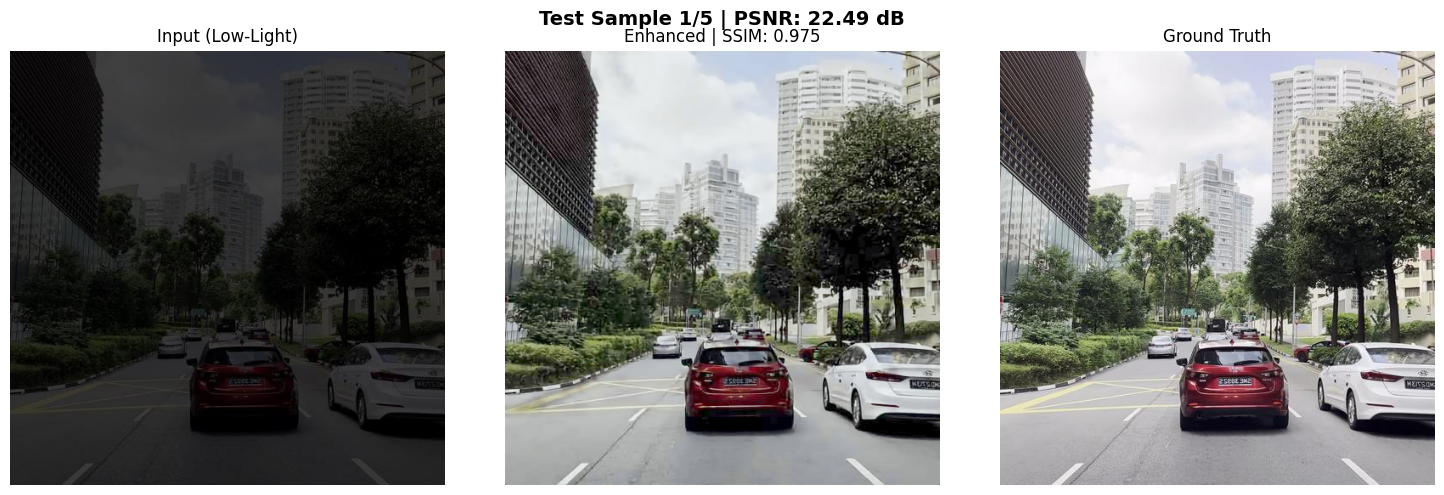

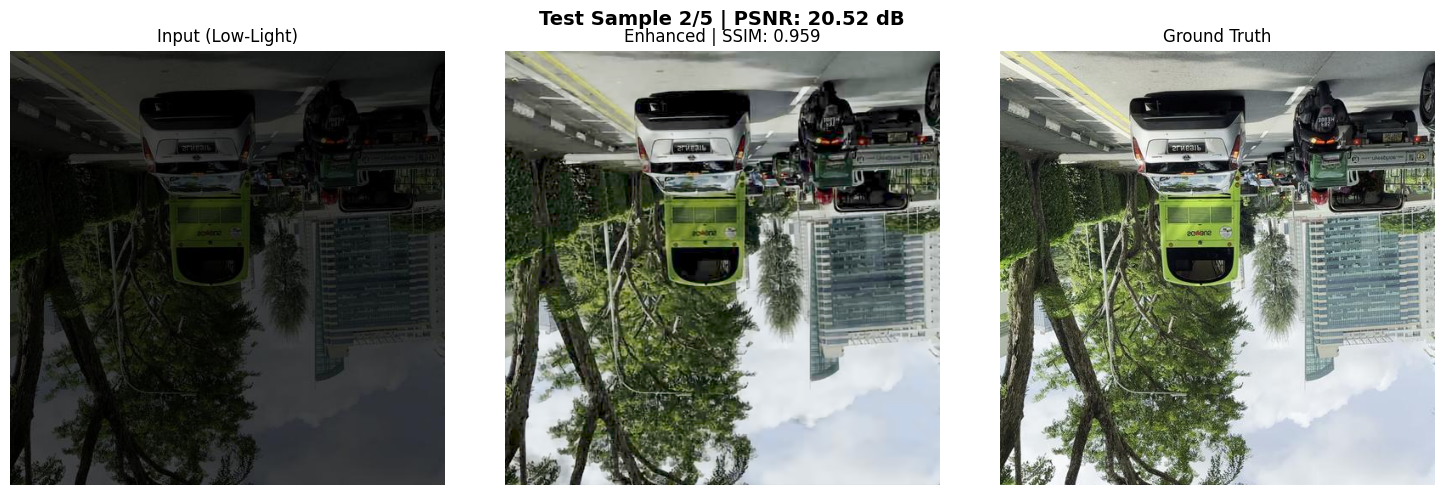

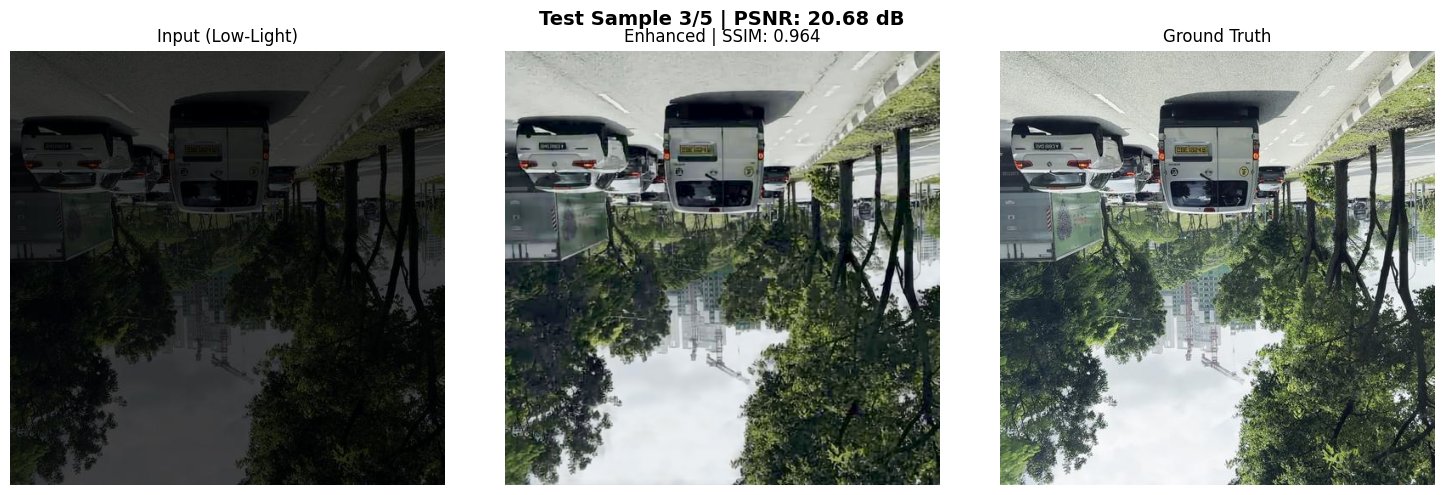

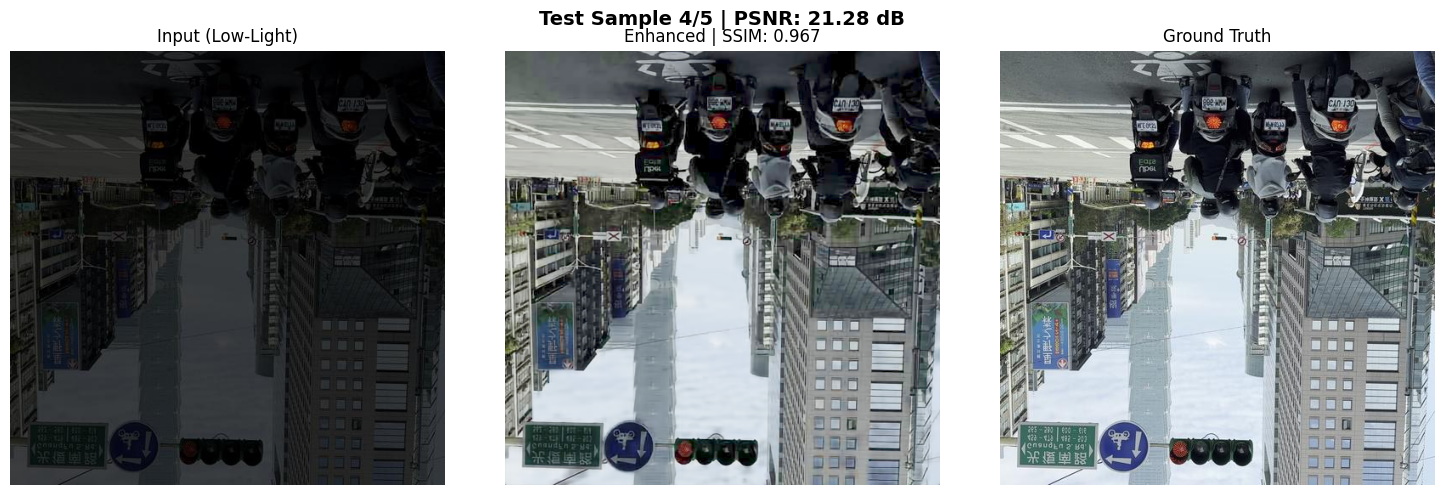

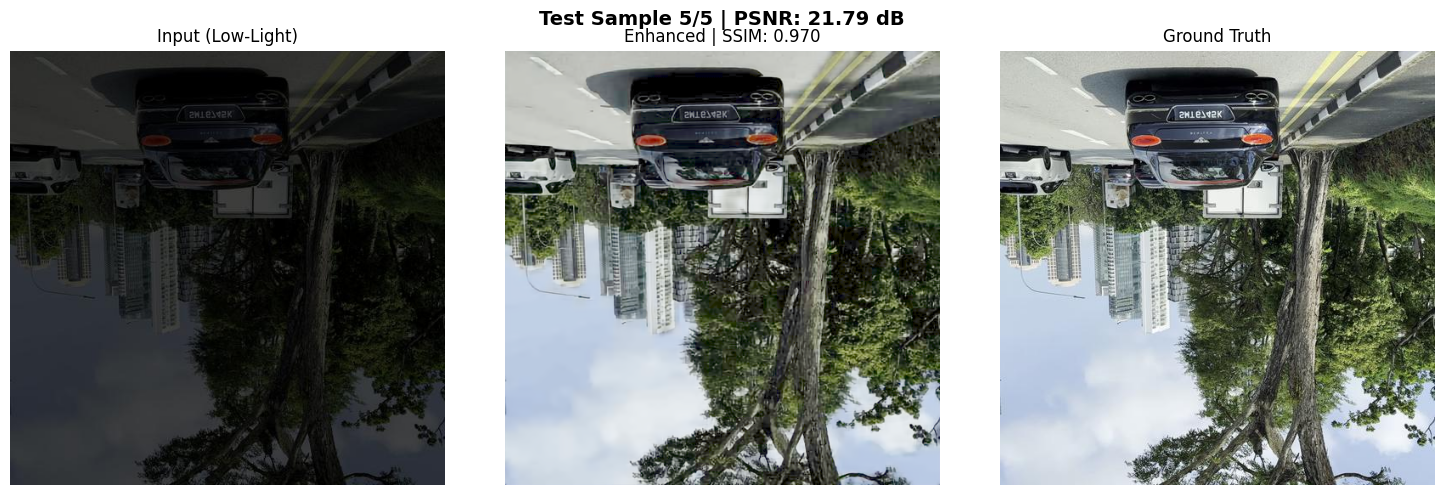


                        📊 PERFORMANCE SUMMARY                         
Samples Tested: 5
Average SSIM:   0.9670 (closer to 1.0 is better)
Average PSNR:   21.35 dB (higher is better)
Best SSIM:      0.9754
Worst SSIM:     0.9587


In [116]:
def test_model_performance(num_samples=5):
    """
    Comprehensive performance test on validation set
    Shows side-by-side comparisons and calculates metrics
    """
    print("=" * 70)
    print(f"{'🧪 MODEL PERFORMANCE TEST':^70}")
    print("=" * 70)
    
    model.eval()
    test_ssim_scores = []
    test_psnr_scores = []
    
    with torch.no_grad():
        for idx, (low_img, high_img) in enumerate(val_loader):
            if idx >= num_samples:
                break
            
            low_img = low_img.to(device)
            high_img = high_img.to(device)
            
            # Enhance
            curve_params = model(low_img)
            enhanced_img = enhance_image(low_img, curve_params, NUM_ITERATIONS)
            
            # Calculate metrics
            ssim_score = calculate_ssim_metric(enhanced_img, high_img)
            
            # Calculate PSNR
            mse = torch.mean((enhanced_img - high_img) ** 2).item()
            psnr_score = 20 * np.log10(1.0 / np.sqrt(mse)) if mse > 0 else 100.0
            
            test_ssim_scores.append(ssim_score)
            test_psnr_scores.append(psnr_score)
            
            # Visualize
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            
            def to_numpy(tensor):
                return tensor.squeeze(0).permute(1, 2, 0).cpu().numpy().clip(0, 1)
            
            axes[0].imshow(to_numpy(low_img))
            axes[0].set_title('Input (Low-Light)', fontsize=12)
            axes[0].axis('off')
            
            axes[1].imshow(to_numpy(enhanced_img))
            axes[1].set_title(f'Enhanced | SSIM: {ssim_score:.3f}', fontsize=12)
            axes[1].axis('off')
            
            axes[2].imshow(to_numpy(high_img))
            axes[2].set_title('Ground Truth', fontsize=12)
            axes[2].axis('off')
            
            plt.suptitle(f'Test Sample {idx+1}/{num_samples} | PSNR: {psnr_score:.2f} dB', 
                        fontsize=14, fontweight='bold')
            plt.tight_layout()
            plt.show()
    
    # Print summary statistics
    avg_ssim = np.mean(test_ssim_scores)
    avg_psnr = np.mean(test_psnr_scores)
    
    print("\n" + "=" * 70)
    print(f"{'📊 PERFORMANCE SUMMARY':^70}")
    print("=" * 70)
    print(f"Samples Tested: {len(test_ssim_scores)}")
    print(f"Average SSIM:   {avg_ssim:.4f} (closer to 1.0 is better)")
    print(f"Average PSNR:   {avg_psnr:.2f} dB (higher is better)")
    print(f"Best SSIM:      {max(test_ssim_scores):.4f}")
    print(f"Worst SSIM:     {min(test_ssim_scores):.4f}")
    print("=" * 70)
    
    return test_ssim_scores, test_psnr_scores


# Run performance test
print("🔍 Testing model on validation samples...")
ssim_scores, psnr_scores = test_model_performance(num_samples=5)

### 🎯 How to Test Your Model:

#### **On Kaggle (No Webcam Needed):**

1. **Quick Test** (Above cell):
   - Tests on 5 validation samples
   - Shows visual comparisons
   - Calculates SSIM and PSNR metrics

2. **Batch Test on Test Set**:
   ```python
   # Process all test images
   batch_enhance_images(
       input_dir="/kaggle/input/loli-street-low-light-image-enhancement-of-street/LoLI-Street Dataset/Test",
       output_dir="/kaggle/working/enhanced_outputs",
       max_images=None  # Process all
   )
   ```
   - Results saved to `/kaggle/working/enhanced_outputs/`
   - Download from Output tab before session ends
   - Compare before/after visually

3. **Custom Image Testing**:
   ```python
   # Test on your own uploaded image
   test_inference(image_path="/kaggle/input/your-image.jpg")
   ```

---

**💡 Tip:** Download your `best_model.pth` and `zero_dce_model.onnx` from the Output tab to use them later!